## Importation des Bibliothèques

In [2]:
# Cellule 1 : Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
import multiprocessing
from keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
import plotly.express as px
from tensorflow.keras import layers, models
# Visualisation de l'accuracy et de la loss
import matplotlib.pyplot as plt




2024-11-17 17:21:53.908176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 17:21:53.909577: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 17:21:53.971454: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 17:21:54.187350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 17:21:55.490023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Chargement et Lecture  du dataset Agricultural-crops

In [4]:
# Cellule 2 : Chargement des données
path = 'Agricultural-crops'
file_name = os.listdir(path)

# Lecture des sous-dossiers (classes)
key_value = dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path + '/' + i)


In [6]:
print(file_name)

# Cellule 3 : Construction du DataFrame
df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key, path + '/' + key + '/' + j])
df1 = pd.DataFrame(df, columns=('label', 'path'))
df1.head()

['tea', 'jute', 'maize', 'sugarcane', 'Pearl_millet(bajra)', 'Cucumber', 'chilli', 'cotton', 'pineapple', 'Cherry', 'tomato', 'rice', 'Lemon', 'banana', 'wheat', 'cardamom', 'Fox_nut(Makhana)', 'soyabean', 'sunflower', 'gram', 'Tobacco-plant', 'Coffee-plant', 'clove', 'jowar', 'papaya', 'Olive-tree', 'coconut', 'vigna-radiati(Mung)', 'almond', 'mustard-oil']


,label,path
0,tea,Agricultural-crops/tea/images5.jpg
1,tea,Agricultural-crops/tea/image24.jpeg
2,tea,Agricultural-crops/tea/image19.jpeg
3,tea,Agricultural-crops/tea/image9.jpeg
4,tea,Agricultural-crops/tea/image30.jpeg


In [10]:
# Comptez les images par classe
classes=file_name
class_counts = {
    cls: len(os.listdir(os.path.join(path, cls)))
    for cls in classes
}

# Convertir en DataFrame pour utilisation avec Plotly
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Classe", "Nombre d'images"])

# Affichage du DataFrame
print(df_counts)


                 Classe  Nombre d'images
0                   tea               23
1                  jute               23
2                 maize               31
3             sugarcane               25
4   Pearl_millet(bajra)               39
5              Cucumber               31
6                chilli               23
7                cotton               32
8             pineapple               25
9                Cherry               32
10               tomato               26
11                 rice               29
12                Lemon               28
13               banana               31
14                wheat               31
15             cardamom               22
16     Fox_nut(Makhana)               23
17             soyabean               30
18            sunflower               24
19                 gram               25
20        Tobacco-plant               33
21         Coffee-plant               29
22                clove               30
23              

In [11]:
# Cellule 4 : Fonction pour lire et redimensionner les images
def read(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    return img


In [12]:
# Cellule 5 : Chargement des images avec multiprocessing
with multiprocessing.Pool(4) as p:
    images = p.map(read, df1['path'])

images = np.array(images, dtype='float')

## 1. Vérification et Exploration des Classes


In [13]:
# Visualisation interactive de la distribution des classes
fig = px.bar(
    df_counts,
    x="Classe",
    y="Nombre d'images",
    title="Distribution des images par classe",
    color="Nombre d'images",
    text="Nombre d'images",
    labels={"Classe": "Type de culture", "Nombre d'images": "Nombre d'images"},
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


## 2. Chargement et Prétraitement des Images

. Le chargement des images avec cv2 et multiprocessing. 

In [14]:
# Je vais  :
# Normaliser les images.
# Ajouter une colonne dans votre DataFrame pour stocker les données en mémoire.
# Ajout de normalisation et d'intégration au DataFrame :

# Normalisation des images
images = images / 255.0  # Les valeurs seront dans [0, 1]

# Ajout des images en mémoire dans le DataFrame
df1['image'] = list(images)


## 3. Visualisation d'Échantillons d'Images


In [23]:
# Pour chaque classe, Je  vais afficher quelques exemples avec Plotly.

# Visualisation d'échantillons d'images
def plot_samples(df, num_samples=1):
    samples = df.groupby('label').apply(lambda x: x.sample(num_samples))
    fig = px.imshow(
        np.hstack([np.array(sample['image']) for _, sample in samples.iterrows()]),
        title="Échantillons d'images par classe",
    )
    fig.show()

# Afficher 1 exemple par classe
plot_samples(df1[:100])
plot_samples(df1[100:200])
plot_samples(df1[200:300])
plot_samples(df1[300:500])
plot_samples(df1[700:])





/tmp/ipykernel_91007/2626415876.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/tmp/ipykernel_91007/2626415876.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/tmp/ipykernel_91007/2626415876.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/tmp/ipykernel_91007/2626415876.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/tmp/ipykernel_91007/2626415876.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## 4. Division du Dataset


In [83]:
# Création des ensembles d'entraînement, validation et test
train, temp = train_test_split(df1, test_size=0.3, stratify=df1['label'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

print(f"Entrainement: {len(train)} images, Validation: {len(val)} images, Test: {len(test)} images")


Entrainement: 580 images, Validation: 124 images, Test: 125 images


## 5. Augmentation des Données avec ImageDataGenerator

In [84]:
# Je vais  utiliser Keras ImageDataGenerator pour augmenter les images d'entraînement. 
# Cela permettra de générer des transformations aléatoires des images et d'améliorer la généralisation de votre modèle.



# Définir un générateur pour l'entraînement avec augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    rotation_range=40,  # Rotation aléatoire des images
    width_shift_range=0.2,  # Déplacement horizontal aléatoire
    height_shift_range=0.2,  # Déplacement vertical aléatoire
    shear_range=0.2,  # Cisaillement des images
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retourner horizontalement les images
    fill_mode='nearest'  # Remplir les pixels vides après transformation
)

# Définir un générateur pour la validation sans augmentation des données
val_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation des pixels pour la validation

# Charger les données d'entraînement depuis le répertoire 'train' (les sous-dossiers sont les classes)
train_generator = train_datagen.flow_from_directory(
    path,  
    target_size=(224, 224),  # Redimensionner les images à 224x224 pour MobileNetV2
    batch_size=32,  # Taille du batch
    class_mode='categorical',  # Le mode d'étiquetage pour plusieurs classes
    shuffle=True  # Mélanger les images
)

# Charger les données de validation depuis le répertoire 'val'
val_generator = val_datagen.flow_from_directory(
    path,  # Remplacez par le chemin vers votre dataset
    target_size=(224, 224),  # Redimensionner les images à 224x224
    batch_size=32,  # Taille du batch
    class_mode='categorical',  # Le mode d'étiquetage pour plusieurs classes
    shuffle=False  # Pas de mélange pour les données de validation
)

# Vérification des classes et des étiquettes
print(f"Classes : {train_generator.class_indices}")



Found 829 images belonging to 30 classes.
Found 829 images belonging to 30 classes.
Classes : {'Cherry': 0, 'Coffee-plant': 1, 'Cucumber': 2, 'Fox_nut(Makhana)': 3, 'Lemon': 4, 'Olive-tree': 5, 'Pearl_millet(bajra)': 6, 'Tobacco-plant': 7, 'almond': 8, 'banana': 9, 'cardamom': 10, 'chilli': 11, 'clove': 12, 'coconut': 13, 'cotton': 14, 'gram': 15, 'jowar': 16, 'jute': 17, 'maize': 18, 'mustard-oil': 19, 'papaya': 20, 'pineapple': 21, 'rice': 22, 'soyabean': 23, 'sugarcane': 24, 'sunflower': 25, 'tea': 26, 'tomato': 27, 'vigna-radiati(Mung)': 28, 'wheat': 29}


## 6. Création du Modèle avec MobileNetV2


In [85]:
# # Je vais  intégrer MobileNetV2 pour la classification des images, en l'utilisant avec une technique de transfert learning. 
# # Je vais ajouter des couches supplémentaires à MobileNetV2 pour ajuster le modèle à mon problème spécifique.




# # Chargement de MobileNetV2 sans la couche de classification finale (top)
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Congeler les couches du modèle de base pour éviter l'entraînement
# base_model.trainable = False

# # Vérification des classes dans df1
# num_classes = len(df1['label'].unique())
# print(f"Nombre de classes : {num_classes}")

# # Construction du modèle
# model = models.Sequential([
#     base_model,                              # MobileNetV2
#     layers.GlobalAveragePooling2D(),          # Pooling global
#     layers.Dense(512, activation='relu'),     # Couche dense
#     layers.Dropout(0.5),                     # Dropout pour éviter le sur-apprentissage
#     layers.Dense(num_classes, activation='softmax')  # Couche de sortie
# ])

# # Compilation du modèle
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [86]:
# Cellule 6 : Construction du modèle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches de base
base_model.trainable = False

# Construire le modèle
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Nombre de classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 7. Entraînement du Modèle


Epoch 1/10


/home/gblack98/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 973ms/step - accuracy: 0.1108 - loss: 3.7498 - val_accuracy: 0.5742 - val_loss: 1.6832 - learning_rate: 0.0010
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 996ms/step - accuracy: 0.4328 - loss: 2.0576 - val_accuracy: 0.7177 - val_loss: 1.1336 - learning_rate: 0.0010
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 994ms/step - accuracy: 0.5451 - loss: 1.5008 - val_accuracy: 0.7793 - val_loss: 0.8135 - learning_rate: 0.0010
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 984ms/step - accuracy: 0.6348 - loss: 1.2702 - val_accuracy: 0.7961 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 963ms/step - accuracy: 0.6736 - loss: 1.0924 - val_accuracy: 0.8203 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 956ms/step - accuracy: 0.7437 - loss: 0.8944 - val_accuracy: 0.8239 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 963ms/step - accuracy: 0.7410 - loss: 0.8718 - val_

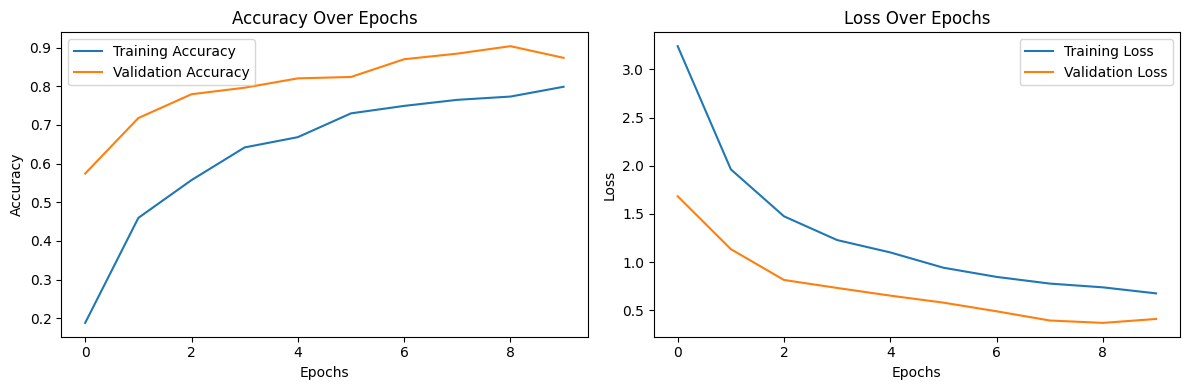

In [ ]:
# Cellule 7 : Entraînement du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Nombre de batches par époque
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,  # Nombre de batches pour la validation
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)]
)
# Cellule 8 : Visualisation de l'accuracy et de la loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
# Cellule 9 : Évaluation du modèle sur le jeu de test
test_generator = val_datagen.flow_from_directory(
    path,  # Replace with your test data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Found 829 images belonging to 30 classes.
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.8570 - loss: 0.4217
Test Accuracy: 87.33%


## 8. Évaluation et Visualisation des Performances


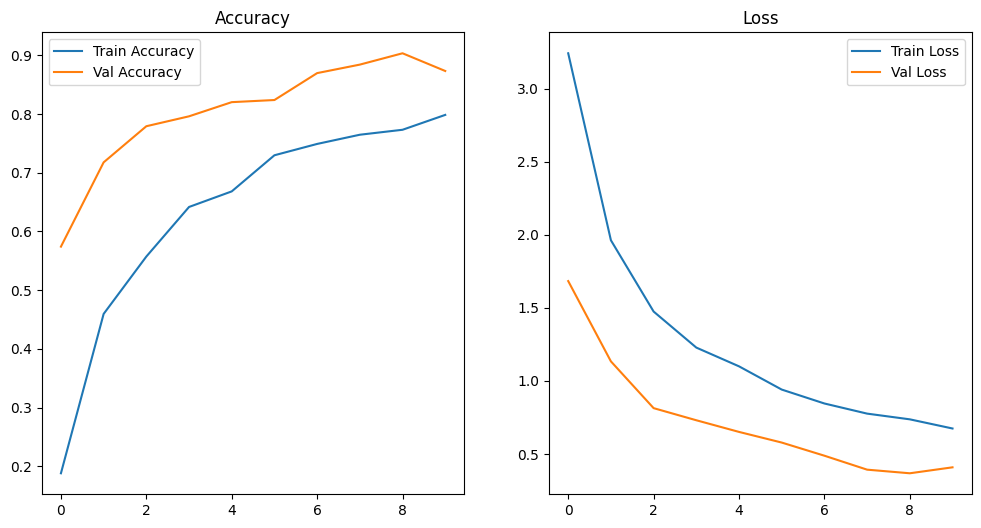

In [90]:
# Pour évaluer et visualiser les performances de mon modèle, j'ai tracé les courbes d'entraînement et de validation, telles que la perte et l'exactitude au fil des époques.

# Visualisation de l'accuracy et de la loss

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

# Affichage des courbes
plot_history(history)


In [ ]:
# Cellule 10 : Sauvegarder le modèle
model.save('model/Gabar_agriculture_crop_classifier.keras')


In [91]:
print(df1.head())  # Affiche les 5 premières lignes pour vérifier la structure


  label                                               path  \
0   tea  /home/gblack98/Téléchargements/Projet Classifi...   
1   tea  /home/gblack98/Téléchargements/Projet Classifi...   
2   tea  /home/gblack98/Téléchargements/Projet Classifi...   
3   tea  /home/gblack98/Téléchargements/Projet Classifi...   
4   tea  /home/gblack98/Téléchargements/Projet Classifi...   

                                               image  
0  [[[0.4117647058823529, 0.6078431372549019, 0.4...  
1  [[[0.0196078431372549, 0.06274509803921569, 0....  
2  [[[0.996078431372549, 0.996078431372549, 0.996...  
3  [[[0.12156862745098039, 0.40784313725490196, 0...  
4  [[[0.1568627450980392, 0.27450980392156865, 0....  
